Modules found on network:
S5-3 | S-0038
S5-3 | S-0009
S5-3 | S-0033
S5-3 | S-0036
S5-3 | S-0025
S5-3 | S-0016
Teach-In Started...
Recording...
Recording done.
Recorded 934 samples.


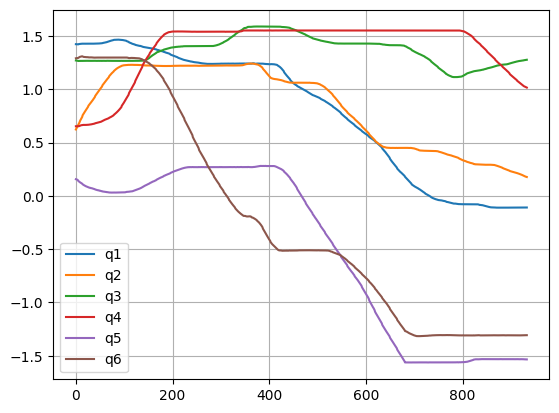

Replay Started...
Finished Replay.
Program Finished.


In [8]:
import hebi
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt

# Initialize HEBI Lookup
lookup = hebi.Lookup()
sleep(2)  # Allow time to discover modules

print('Modules found on network:')
for entry in lookup.entrylist:
    print(f'{entry.family} | {entry.name}')
    
# Initialize group
group = lookup.get_group_from_names(['S5-3'], ['S-0038', 'S-0009', 'S-0033', 'S-0025', 'S-0036', 'S-0016'])
if group is None:
    raise RuntimeError("Group could not be found!")


# Command settings
group_command = hebi.GroupCommand(group.size)
group_feedback = hebi.GroupFeedback(group.size)

# Define parameters
frequency = 100  # Hz
recording_time = 10  # seconds
time_step = 1 / frequency  # time step based on frequency

# Preallocate Q for position data
Q = np.zeros((int(recording_time * frequency), group.size))
row = 0

# Record trajectory
print('Teach-In Started...')
print('Recording...')
start_time = time()
while (time() - start_time) < recording_time:
    # Get feedback
    group.get_next_feedback(reuse_fbk=group_feedback)
    Q[row, :] = group_feedback.position
    row += 1
    
    # Send zero effort command
    group_command.effort = np.zeros(group.size)
    group.send_command(group_command)
    
    # Sleep for the rest of the time step
    sleep(time_step)

print('Recording done.')
print(f'Recorded {row} samples.')

# Trim Q to remove unused rows
Q = Q[:row, :]

# Plot the trajectory
plt.plot(Q)
plt.legend([f'q{i+1}' for i in range(group.size)])
plt.grid(True)
plt.show()

# Pause before playback
sleep(5)
print('Replay Started...')

# Replay recorded trajectory in reverse
for i in range(row-1, -1, -1):
    group_command.position = Q[i, :]
    group.send_command(group_command)
    sleep(time_step)

print('Finished Replay.')

# Reset and finalize
print('Program Finished.')


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])
############# ここから描画用 #######################
def draw_link_coordinate(ax, matrix, axes_length):
    origin = matrix @ np.array([[0], [0], [0], [1]])
    origin = origin[:3].flatten()

    x_dir = matrix @ np.array([[axes_length], [0], [0], [1]])
    y_dir = matrix @ np.array([[0], [axes_length], [0], [1]])
    z_dir = matrix @ np.array([[0], [0], [axes_length], [1]])

    ax.plot([origin[0], x_dir[0, 0]], [origin[1], x_dir[1, 0]], [origin[2], x_dir[2, 0]], color="red")
    ax.plot([origin[0], y_dir[0, 0]], [origin[1], y_dir[1, 0]], [origin[2], y_dir[2, 0]], color="green")
    ax.plot([origin[0], z_dir[0, 0]], [origin[1], z_dir[1, 0]], [origin[2], z_dir[2, 0]], color="blue")

def main(*args, **kwargs):
    params = kwargs
    link_length = 3.5    

    theta1 = np.deg2rad(params["0"])
    theta2 = np.deg2rad(params["1"])
    theta3 = np.deg2rad(params["2"])
    theta4 = np.deg2rad(params["3"])
    theta5 = np.deg2rad(params["4"])
    theta6 = np.deg2rad(params["5"])

    # 各リンクの変換行列
    T12 = hebi_transformed_matrix(link_length, theta1)
    T23 = hebi_transformed_matrix(link_length, theta2)
    T34 = hebi_transformed_matrix(link_length, theta3)
    T45 = hebi_transformed_matrix(link_length, theta4)
    T56 = hebi_transformed_matrix(link_length, theta5)
    T6e = hebi_transformed_matrix(link_length, theta6)
    

    # 各リンクの座標をリストに格納
    points = [np.array([[0], [0], [0], [1]])]  # 基準座標
    T_current = np.eye(4)

    for T in [T12, T23, T34, T45, T56, T6e]:
        T_current = T_current @ T
        points.append(T_current @ np.array([[0], [0], [0], [1]]))

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # 各リンクを描画
    for i in range(len(points) - 1):
        ax.plot([points[i][0, 0], points[i+1][0, 0]], 
                [points[i][1, 0], points[i+1][1, 0]], 
                [points[i][2, 0], points[i+1][2, 0]], "o-", ms=6)

    # 各リンクの座標系を描画
    axes_length = link_length*0.4
    T_current = np.eye(4)
    draw_link_coordinate(ax, np.eye(4), axes_length)
    for T in [T12, T23, T34, T45, T56, T6e]:
        T_current = T_current @ T
        draw_link_coordinate(ax, T_current, axes_length)

    # グラフの設定
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])

    plt.show()

def generate_vbox_slider_widget(link_num):
    slider_widgets = []
    for i in range(link_num):
        slider_widgets.append(ipywidgets.FloatSlider(value=0.0, min=-90.0, max=90.0, description=f"param{i+1}", disabled=False))
    return ipywidgets.VBox(slider_widgets)

def generate_vbox_text_widget(link_num):
    text_widgets = []
    for i in range(link_num):
        text_widgets.append(ipywidgets.FloatText(min=-90.0, max=90.0))
    return ipywidgets.VBox(text_widgets)

def link_slider_and_text(box1, box2, link_num):
    for i in range(link_num):
        ipywidgets.link((box1.children[i], 'value'), (box2.children[i], 'value'))

def draw_interactive(link_num):
    posture_sliders = generate_vbox_slider_widget(link_num)
    posture_texts = generate_vbox_text_widget(link_num)
    slider_and_text = ipywidgets.Box([posture_sliders, posture_texts])
    link_slider_and_text(posture_sliders, posture_texts, link_num)

    reset_button = ipywidgets.Button(description="Reset")
    def reset_values(button):
        for i in range(link_num):
            posture_sliders.children[i].value = 0.0
    reset_button.on_click(reset_values)

    params = {str(i): posture_sliders.children[i] for i in range(link_num)}
    final_widgets = ipywidgets.interactive_output(main, params)

    display(slider_and_text, reset_button, final_widgets)

draw_interactive(6)


Box(children=(VBox(children=(FloatSlider(value=0.0, description='param1', max=90.0, min=-90.0), FloatSlider(va…

Button(description='Reset', style=ButtonStyle())

Output()

Modules found on network:
S5-3 | S-0038
S5-3 | S-0033
S5-3 | S-0009
S5-3 | S-0036
S5-3 | S-0025
S5-3 | S-0016


C:\Users\kenta\AppData\Local\Temp\ipykernel_47912\2545868980.py:111: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, interval=time_step*1000)


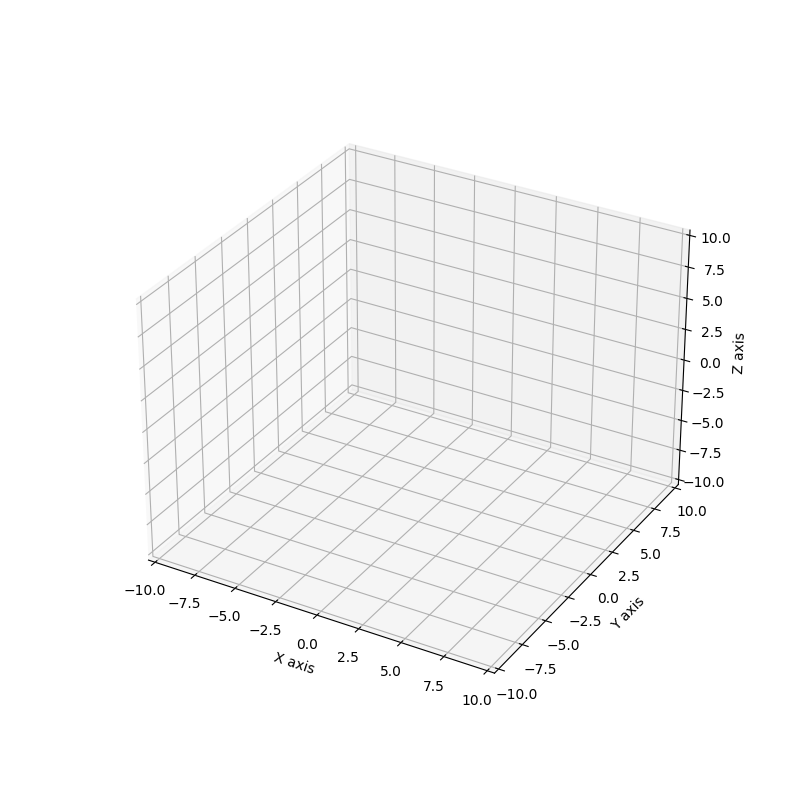

In [9]:
import hebi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from time import sleep
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

# Initialize HEBI Lookup
lookup = hebi.Lookup()
sleep(2)  # Allow time to discover modules

print('Modules found on network:')
for entry in lookup.entrylist:
    print(f'{entry.family} | {entry.name}')

# Initialize group
group = lookup.get_group_from_names(['S5-3'], ['S-0033', 'S-0009', 'S-0025', 'S-0036', 'S-0038', 'S-0016'])
# group = lookup.get_group_from_names(['S5-3'], ['S-0038', 'S-0009', 'S-0033', 'S-0025', 'S-0036', 'S-0016'])
if group is None:
    raise RuntimeError("Group could not be found!")

# Command settings
group_command = hebi.GroupCommand(group.size)
group_feedback = hebi.GroupFeedback(group.size)
# Parameters
link_length= 3.5  # Each link length
time_step = 0.2  # seconds

def hebi_transformed_matrix(link_length, theta):
    return np.array([[0, -np.cos(theta), np.sin(theta), link_length * np.sin(theta)],
                     [1, 0, 0, 0],
                     [0, np.sin(theta), np.cos(theta), link_length * np.cos(theta)],
                     [0, 0, 0, 1]])
    
############# ここから描画用 #######################
def draw_link_coordinate(ax, matrix, axes_length):
    origin = matrix @ np.array([[0], [0], [0], [1]])
    origin = origin[:3].flatten()

    x_dir = matrix @ np.array([[axes_length], [0], [0], [1]])
    y_dir = matrix @ np.array([[0], [axes_length], [0], [1]])
    z_dir = matrix @ np.array([[0], [0], [axes_length], [1]])

    ax.plot([origin[0], x_dir[0, 0]], [origin[1], x_dir[1, 0]], [origin[2], x_dir[2, 0]], color="red")
    ax.plot([origin[0], y_dir[0, 0]], [origin[1], y_dir[1, 0]], [origin[2], y_dir[2, 0]], color="green")
    ax.plot([origin[0], z_dir[0, 0]], [origin[1], z_dir[1, 0]], [origin[2], z_dir[2, 0]], color="blue")

# 3Dアニメーション関数
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
axes_length = link_length * 0.4
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_zlim([-10, 10])
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")

# Update function for the animation
def update(frame):
    group_command.effort = np.zeros(group.size)
    # Clear the axes
    ax.cla()
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_zlim([-10, 10])
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")

    # Get feedback
    if group.get_next_feedback(reuse_fbk=group_feedback) is None:
        print("Failed to get feedback from HEBI modules.")
        return

    # Retrieve joint angles
    theta1, theta2, theta3, theta4, theta5, theta6 = group_feedback.position

    # 各リンクの変換行列
    T12 = hebi_transformed_matrix(link_length, theta1)
    T23 = hebi_transformed_matrix(link_length, theta2)
    T34 = hebi_transformed_matrix(link_length, theta3)
    T45 = hebi_transformed_matrix(link_length, theta4)
    T56 = hebi_transformed_matrix(link_length, theta5)
    T6e = hebi_transformed_matrix(link_length, theta6)
    

    # 各リンクの座標を計算
    points = [np.array([[0], [0], [0], [1]])]  # 基準座標
    T_current = np.eye(4)

    for T in [T12, T23, T34, T45, T56, T6e]:
        T_current = T_current @ T
        points.append(T_current @ np.array([[0], [0], [0], [1]]))

    # 各リンクを描画
    for i in range(len(points) - 1):
        ax.plot([points[i][0, 0], points[i+1][0, 0]], 
                [points[i][1, 0], points[i+1][1, 0]], 
                [points[i][2, 0], points[i+1][2, 0]], "o-", ms=6)

    # 各リンクの座標系を描画
    T_current = np.eye(4)
    draw_link_coordinate(ax, np.eye(4), axes_length)
    for T in [T12, T23, T34, T45, T56, T6e]:
        T_current = T_current @ T
        draw_link_coordinate(ax, T_current, axes_length)

# Create the animation and keep the reference in `ani`
ani = FuncAnimation(fig, update, interval=time_step*1000)

# Display the plot
plt.show()